In [1]:
# =============================================================================
# Robustness & Improvements: 
# Do a quick call with Hicham before starting this part tomorrow 11 AM 
# =============================================================================

#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import combinations

# Try to import python-docx, install if missing
try:
    from docx import Document
except ImportError:
    !pip install python-docx --quiet
    from docx import Document

from docx.shared import Inches

plt.rcParams["figure.figsize"] = (8, 5)

# ---------- CONFIG: file paths ----------
TRADES_PATH = "trades_with_clusters.csv"
CANDLES_PATH = "XAUUSD_5min_candles.csv"
REPORT_DOCX_PATH = "imperium_robustness_improvements_report.docx"

# ---------- CONFIG: TRADES column names ----------
TRADES_DATETIME_COL = "entry_time"     # entry timestamp
TRADES_EXIT_COL = "exit_time"          # exit timestamp (if present)
TRADES_PROFIT_COL = "profit"
TRADES_CLUSTER_COL = "cluster"         # 0,1,2,3

# Indicators already in trades_with_clusters (adapt if names differ)
ENTRY_ADX_COL = "entry_ADX(14)"
ENTRY_RSI_COL = "entry_RSI(14)"
ENTRY_STOCHK_COL = "entry_StochK(14)"
ENTRY_BB_UPPER_COL = "entry_BB_Upper"
ENTRY_BB_MID_COL = "entry_BB_Mid"
ENTRY_BB_LOWER_COL = "entry_BB_Lower"
ENTRY_SPREAD_COL_TRADE = "entry_Spread (Pips)"  # if exists

ENTRY_MACD_MAIN_COL = "entry_MACD Main"
ENTRY_MACD_SIGNAL_COL = "entry_MACD Signal"

print("Config loaded.")


Config loaded.


In [2]:

# Load trades_with_clusters and XAUUSD_5min_candles


# Read trades (UTF-8, standard CSV)
trades = pd.read_csv(TRADES_PATH, encoding="utf-8")

# Read candles (UTF-16, semicolon-separated, from MT5)
candles = pd.read_csv(
    CANDLES_PATH,
    encoding="utf-16",
    sep=";",
    engine="python"
)

print("Trades columns:", trades.columns.tolist())
print("Candles columns:", candles.columns.tolist())
display(candles.head(3))

# --- CONFIG for candle columns (adapt if needed) ---
CANDLES_DATETIME_COL = "Timestamp"      # from candles.columns
CANDLE_SPREAD_COL = "Spread (Pips)"     # exact name
CANDLE_ATR_COL = "ATR(14)"              # exact name

# Parse datetimes
trades[TRADES_DATETIME_COL] = pd.to_datetime(trades[TRADES_DATETIME_COL])
if TRADES_EXIT_COL in trades.columns:
    trades[TRADES_EXIT_COL] = pd.to_datetime(trades[TRADES_EXIT_COL])

candles[CANDLES_DATETIME_COL] = pd.to_datetime(
    candles[CANDLES_DATETIME_COL],
    format="%Y.%m.%d %H:%M"  # matches e.g. "2024.06.25 20:10" i dont think if it will work for all but need test 
)

# Sort for merge_asof this is important 1h to test ughhhhhh
trades = trades.sort_values(TRADES_DATETIME_COL).reset_index(drop=True)
candles = candles.sort_values(CANDLES_DATETIME_COL).reset_index(drop=True)

print("Trades shape:", trades.shape)
print("Candles shape:", candles.shape)
display(trades.head(3))
display(candles.head(3))


Trades columns: ['entry_order', 'entry_deal', 'entry_time', 'entry_price', 'entry_balance', 'entry_comment_deal', 'entry_comment_order', 'exit_order', 'exit_deal', 'exit_time', 'exit_price', 'exit_balance', 'profit', 'exit_comment_deal', 'exit_comment_order', 'entry_Timestamp', 'entry_Open', 'entry_High', 'entry_Low', 'entry_Close', 'entry_Spread (Pips)', 'entry_RSI(14)', 'entry_MA(20,SMA)', 'entry_MACD Main', 'entry_MACD Signal', 'entry_ATR(14)', 'entry_ADX(14)', 'entry_plusDI(14)', 'entry_minusDI(14)', 'entry_StochK(14)', 'entry_StochD(14)', 'entry_BB_Upper', 'entry_BB_Mid', 'entry_BB_Lower', 'entry_candle_time', 'exit_Timestamp', 'exit_Open', 'exit_High', 'exit_Low', 'exit_Close', 'exit_Spread (Pips)', 'exit_RSI(14)', 'exit_MA(20,SMA)', 'exit_MACD Main', 'exit_MACD Signal', 'exit_ATR(14)', 'exit_ADX(14)', 'exit_plusDI(14)', 'exit_minusDI(14)', 'exit_StochK(14)', 'exit_StochD(14)', 'exit_BB_Upper', 'exit_BB_Mid', 'exit_BB_Lower', 'exit_candle_time', 'duration_hours', 'trade_duration_

,Timestamp,Open,High,Low,Close,Spread (Pips),RSI(14),"MA(20,SMA)",MACD Main,MACD Signal,ATR(14),ADX(14),plusDI(14),minusDI(14),StochK(14),StochD(14),BB_Upper,BB_Mid,BB_Lower
0,2024.06.25 20:10,2316.61,2318.21,2316.44,2317.37,68.0,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,0.000000,0.0,0.000000,1.797693e+308,1.797693e+308,0.0,0.0,0.0
1,2024.06.25 20:15,2317.38,2318.15,2317.21,2317.97,69.0,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,0.000000,0.0,0.000000,1.797693e+308,1.797693e+308,0.0,0.0,0.0
2,2024.06.25 20:20,2317.97,2318.17,2316.98,2317.99,70.0,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,13.333333,0.0,2.577031,1.797693e+308,1.797693e+308,0.0,0.0,0.0


Trades shape: (430, 58)
Candles shape: (100022, 19)


,entry_order,entry_deal,entry_time,entry_price,entry_balance,entry_comment_deal,entry_comment_order,exit_order,exit_deal,exit_time,...,exit_minusDI(14),exit_StochK(14),exit_StochD(14),exit_BB_Upper,exit_BB_Mid,exit_BB_Lower,exit_candle_time,duration_hours,trade_duration_minutes,cluster
0,2,2,2025-01-07 02:00:00,2634.91,10000.00,IMPERIUM,IMPERIUM,3,3,2025-01-07 15:54:40,...,3.692500,90.974146,87.594666,2664.073822,2654.0605,2644.047178,2025-01-07 15:50:00,13.911111,834.666667,1.0
1,4,4,2025-01-08 07:00:00,2647.28,10027.93,IMPERIUM,IMPERIUM,5,5,2025-01-09 14:58:40,...,11.833418,74.668969,72.537114,2674.713271,2671.2330,2667.752729,2025-01-09 14:55:00,31.977778,1918.666667,0.0
2,6,6,2025-01-13 15:00:00,2671.44,10055.48,IMPERIUM,IMPERIUM,12,12,2025-01-15 16:00:00,...,9.961715,80.998650,69.120279,2691.956486,2686.1825,2680.408514,2025-01-15 16:00:00,49.000000,2940.000000,1.0


,Timestamp,Open,High,Low,Close,Spread (Pips),RSI(14),"MA(20,SMA)",MACD Main,MACD Signal,ATR(14),ADX(14),plusDI(14),minusDI(14),StochK(14),StochD(14),BB_Upper,BB_Mid,BB_Lower
0,2024-06-25 20:10:00,2316.61,2318.21,2316.44,2317.37,68.0,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,0.000000,0.0,0.000000,1.797693e+308,1.797693e+308,0.0,0.0,0.0
1,2024-06-25 20:15:00,2317.38,2318.15,2317.21,2317.97,69.0,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,0.000000,0.0,0.000000,1.797693e+308,1.797693e+308,0.0,0.0,0.0
2,2024-06-25 20:20:00,2317.97,2318.17,2316.98,2317.99,70.0,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,13.333333,0.0,2.577031,1.797693e+308,1.797693e+308,0.0,0.0,0.0


In [3]:
# Merge 5m candle context into trades at entry time


# Select needed candle columns
candle_cols_to_use = [
    CANDLES_DATETIME_COL,
    CANDLE_SPREAD_COL,
    CANDLE_ATR_COL,
]

candles_ctx = candles[candle_cols_to_use].copy()

merged = pd.merge_asof(
    trades.sort_values(TRADES_DATETIME_COL),
    candles_ctx.sort_values(CANDLES_DATETIME_COL),
    left_on=TRADES_DATETIME_COL,
    right_on=CANDLES_DATETIME_COL,
    direction="backward"
)

# Rename candle fields at entry
merged = merged.rename(columns={
    CANDLE_SPREAD_COL: "entry_spread_5m",
    CANDLE_ATR_COL: "entry_ATR_5m",
})

print("Merged shape:", merged.shape)
display(merged[[TRADES_DATETIME_COL, TRADES_CLUSTER_COL, TRADES_PROFIT_COL,
                "entry_spread_5m", "entry_ATR_5m"]].head(5))


Merged shape: (430, 61)


,entry_time,cluster,profit,entry_spread_5m,entry_ATR_5m
0,2025-01-07 02:00:00,1.0,27.93,77.0,0.707857
1,2025-01-08 07:00:00,0.0,27.55,76.0,0.765000
2,2025-01-13 15:00:00,1.0,22.16,93.0,2.989286
3,2025-01-13 15:00:00,1.0,26.09,93.0,2.989286
4,2025-01-13 18:00:00,1.0,31.48,76.0,2.744286


In [4]:
# Feature engineering: time-of-day, session, day-of-week, ATR/spread buckets


# Time-based features i prefer late NY
merged["entry_hour"] = merged[TRADES_DATETIME_COL].dt.hour
merged["entry_dow"] = merged[TRADES_DATETIME_COL].dt.dayofweek  # Monday=0

def map_session(h):
    if 0 <= h < 8:
        return "asian"
    elif 8 <= h < 12:
        return "london"
    elif 12 <= h < 17:
        return "ny_overlap"
    else:
        return "late_us"

merged["entry_session"] = merged["entry_hour"].apply(map_session)

# ATR buckets based on entry_ATR_5m if available
if "entry_ATR_5m" in merged.columns and merged["entry_ATR_5m"].notna().sum() > 0:
    merged["atr_bucket"] = pd.qcut(
        merged["entry_ATR_5m"],
        q=3,
        labels=["low_vol", "med_vol", "high_vol"]
    )
else:
    merged["atr_bucket"] = np.nan

# Spread: prefer trade-level if available, otherwise candle-level blah blah this is a trick better not focus on alll indicator this one is so intresting 
if ENTRY_SPREAD_COL_TRADE in merged.columns:
    merged["entry_spread"] = merged[ENTRY_SPREAD_COL_TRADE]
else:
    merged["entry_spread"] = merged["entry_spread_5m"]

spread_50 = merged["entry_spread"].quantile(0.50)
spread_75 = merged["entry_spread"].quantile(0.75)

merged["spread_bucket"] = pd.cut(
    merged["entry_spread"],
    bins=[-np.inf, spread_50, spread_75, np.inf],
    labels=["low", "med", "high"]
)

display(merged[[
    TRADES_DATETIME_COL, TRADES_CLUSTER_COL, TRADES_PROFIT_COL,
    "entry_hour", "entry_dow", "entry_session",
    "entry_ATR_5m", "atr_bucket",
    "entry_spread", "spread_bucket"
]].head(10))


,entry_time,cluster,profit,entry_hour,entry_dow,entry_session,entry_ATR_5m,atr_bucket,entry_spread,spread_bucket
0,2025-01-07 02:00:00,1.0,27.93,2,1,asian,0.707857,low_vol,77.0,med
1,2025-01-08 07:00:00,0.0,27.55,7,2,asian,0.765000,low_vol,76.0,low
2,2025-01-13 15:00:00,1.0,22.16,15,0,ny_overlap,2.989286,med_vol,93.0,high
3,2025-01-13 15:00:00,1.0,26.09,15,0,ny_overlap,2.989286,med_vol,93.0,high
4,2025-01-13 18:00:00,1.0,31.48,18,0,late_us,2.744286,med_vol,76.0,low
5,2025-01-14 12:00:00,0.0,24.88,12,1,ny_overlap,1.772143,low_vol,70.0,low
6,2025-01-17 08:00:00,0.0,5.53,8,4,london,1.056429,low_vol,72.0,low
7,2025-01-17 12:00:00,1.0,12.41,12,4,ny_overlap,1.652143,low_vol,71.0,low
8,2025-01-17 16:00:00,1.0,21.39,16,4,ny_overlap,2.550714,low_vol,63.0,low
9,2025-01-20 02:00:00,1.0,29.72,2,0,asian,2.360000,low_vol,83.0,high


In [5]:
#  Metrics function and filter definitions per cluster

# following the call notes but I refer that to Bybit always check profit
def compute_metrics(df, profit_col=TRADES_PROFIT_COL):
    n = len(df)
    if n == 0:
        return {"N": 0, "win_rate": np.nan, "avg_profit": np.nan, "total_profit": 0.0}
    wins = (df[profit_col] > 0).sum()
    win_rate = wins / n
    avg_profit = df[profit_col].mean()
    total_profit = df[profit_col].sum()
    return {
        "N": n,
        "win_rate": win_rate,
        "avg_profit": avg_profit,
        "total_profit": total_profit,
    }

# Baseline per cluster
baseline_results = []
for c in sorted(merged[TRADES_CLUSTER_COL].unique()):
    df_c = merged[merged[TRADES_CLUSTER_COL] == c]
    metrics = compute_metrics(df_c)
    metrics["cluster"] = c
    baseline_results.append(metrics)

baseline_df = pd.DataFrame(baseline_results)[
    ["cluster", "N", "win_rate", "avg_profit", "total_profit"]
]
print("Baseline performance per cluster:")
display(baseline_df)

# Safe helpers for quantiles (avoid NaNs / missing columns)
def q_low(series):
    return series.quantile(1/3)

def q_high(series):
    return series.quantile(2/3)

# ---------- FILTERS PER CLUSTER -----------------------------
cluster_filters = {
    0: {
        # Time-based
        "session_asian":   lambda df: df["entry_session"] == "asian",
        "monday_only":     lambda df: df["entry_dow"] == 0,
        "best_hours":      lambda df: df["entry_hour"].isin([2, 8, 10, 19, 20]),
        "low_med_spread":  lambda df: df["spread_bucket"].isin(["low", "med"]),
        # Indicator-based (quantiles)
        "rsi_high_terc":   lambda df: df[ENTRY_RSI_COL] >= q_high(df[ENTRY_RSI_COL]),
        "macd_signal_high":lambda df: df[ENTRY_MACD_SIGNAL_COL] >= q_high(df[ENTRY_MACD_SIGNAL_COL])
                             if ENTRY_MACD_SIGNAL_COL in df.columns else pd.Series(False, index=df.index),
    },
    1: {
        "adx_gt_40":       lambda df: df[ENTRY_ADX_COL] > 40,
        "late_us":         lambda df: df["entry_session"] == "late_us",
        "bb_upper_low":    lambda df: df[ENTRY_BB_UPPER_COL] <= q_low(df[ENTRY_BB_UPPER_COL]),
        "low_med_spread":  lambda df: df["spread_bucket"].isin(["low", "med"]),
    },
    2: {
        "adx_gt_40":       lambda df: df[ENTRY_ADX_COL] > 40,
        "not_monday":      lambda df: df["entry_dow"] != 0,
        "not_asian":       lambda df: df["entry_session"] != "asian",
        "spread_mid":      lambda df: df["spread_bucket"] == "med",
    },
    3: {
        "adx_high_terc":   lambda df: df[ENTRY_ADX_COL] >= q_high(df[ENTRY_ADX_COL]),
        "stoch_60_80":     lambda df: df[ENTRY_STOCHK_COL].between(60, 80),
        "not_thursday":    lambda df: df["entry_dow"] != 3,
        "low_med_spread":  lambda df: df["spread_bucket"].isin(["low", "med"]),
    },
}

print("Filters defined for clusters:", list(cluster_filters.keys()))


Baseline performance per cluster:


,cluster,N,win_rate,avg_profit,total_profit
0,0.0,200,0.705000,11.591950,2318.39
1,1.0,93,0.763441,17.536344,1630.88
2,2.0,76,0.578947,3.926711,298.43
3,3.0,61,0.606557,3.306885,201.72


Filters defined for clusters: [0, 1, 2, 3]


In [6]:

# Evaluate all single filters per cluster

# empty keep it empty
filter_results = []

for c, filt_dict in cluster_filters.items():
    df_c = merged[merged[TRADES_CLUSTER_COL] == c]
    base_metrics = compute_metrics(df_c)
    
    for filt_name, filt_fn in filt_dict.items():
        try:
            mask = filt_fn(df_c)
        except Exception as e:
            print(f"Filter {filt_name} on cluster {c} failed: {e}")
            continue
        
        df_filt = df_c[mask]
        metrics = compute_metrics(df_filt)
        metrics.update({
            "cluster": c,
            "filter": filt_name,
            "baseline_N": base_metrics["N"],
            "baseline_wr": base_metrics["win_rate"],
            "baseline_avg": base_metrics["avg_profit"],
        })
        filter_results.append(metrics)

filters_df = pd.DataFrame(filter_results)
filters_df = filters_df[[
    "cluster", "filter",
    "N", "win_rate", "avg_profit", "total_profit",
    "baseline_N", "baseline_wr", "baseline_avg"
]]

print("All single filters:")
display(filters_df.sort_values(["cluster", "win_rate"], ascending=[True, False]))

print("Single filters with N >= 30:")
good_filters_df = filters_df[filters_df["N"] >= 30].copy()
display(good_filters_df.sort_values(["cluster", "win_rate"], ascending=[True, False]))


All single filters:


,cluster,filter,N,win_rate,avg_profit,total_profit,baseline_N,baseline_wr,baseline_avg
2,0,best_hours,38,0.894737,19.847632,754.21,200,0.705000,11.591950
1,0,monday_only,38,0.842105,21.411316,813.63,200,0.705000,11.591950
0,0,session_asian,42,0.833333,18.292143,768.27,200,0.705000,11.591950
4,0,rsi_high_terc,67,0.820896,16.317761,1093.29,200,0.705000,11.591950
5,0,macd_signal_high,67,0.820896,15.542239,1041.33,200,0.705000,11.591950
3,0,low_med_spread,151,0.715232,10.790000,1629.29,200,0.705000,11.591950
8,1,bb_upper_low,31,0.935484,22.488387,697.14,93,0.763441,17.536344
7,1,late_us,33,0.848485,29.525455,974.34,93,0.763441,17.536344
6,1,adx_gt_40,52,0.807692,22.383846,1163.96,93,0.763441,17.536344
9,1,low_med_spread,63,0.761905,18.229365,1148.45,93,0.763441,17.536344


Single filters with N >= 30:


,cluster,filter,N,win_rate,avg_profit,total_profit,baseline_N,baseline_wr,baseline_avg
2,0,best_hours,38,0.894737,19.847632,754.21,200,0.705000,11.591950
1,0,monday_only,38,0.842105,21.411316,813.63,200,0.705000,11.591950
0,0,session_asian,42,0.833333,18.292143,768.27,200,0.705000,11.591950
4,0,rsi_high_terc,67,0.820896,16.317761,1093.29,200,0.705000,11.591950
5,0,macd_signal_high,67,0.820896,15.542239,1041.33,200,0.705000,11.591950
3,0,low_med_spread,151,0.715232,10.790000,1629.29,200,0.705000,11.591950
8,1,bb_upper_low,31,0.935484,22.488387,697.14,93,0.763441,17.536344
7,1,late_us,33,0.848485,29.525455,974.34,93,0.763441,17.536344
6,1,adx_gt_40,52,0.807692,22.383846,1163.96,93,0.763441,17.536344
9,1,low_med_spread,63,0.761905,18.229365,1148.45,93,0.763441,17.536344


In [7]:
# Evaluate 2-filter combinations per cluster

# empty please to not forget
combo_results = []

for c, filt_dict in cluster_filters.items():
    df_c = merged[merged[TRADES_CLUSTER_COL] == c]
    base_metrics = compute_metrics(df_c)
    filt_names = list(filt_dict.keys())
    
    for combo in combinations(filt_names, 2):  # 2-filter combos
        try:
            mask = np.ones(len(df_c), dtype=bool)
            for fname in combo:
                mask &= filt_dict[fname](df_c)
        except Exception as e:
            print(f"Combo {combo} on cluster {c} failed: {e}")
            continue
        
        df_combo = df_c[mask]
        metrics = compute_metrics(df_combo)
        metrics.update({
            "cluster": c,
            "filters": "&".join(combo),
            "baseline_N": base_metrics["N"],
            "baseline_wr": base_metrics["win_rate"],
            "baseline_avg": base_metrics["avg_profit"],
        })
        combo_results.append(metrics)

combo_df = pd.DataFrame(combo_results)
combo_df = combo_df[[
    "cluster", "filters",
    "N", "win_rate", "avg_profit", "total_profit",
    "baseline_N", "baseline_wr", "baseline_avg"
]]

print("All 2-filter combinations:")
display(combo_df.sort_values(["cluster", "win_rate"], ascending=[True, False]))

print("2-filter combinations with N >= 20:")
good_combo_df = combo_df[combo_df["N"] >= 20].copy()
display(good_combo_df.sort_values(["cluster", "win_rate"], ascending=[True, False]))


All 2-filter combinations:


,cluster,filters,N,win_rate,avg_profit,total_profit,baseline_N,baseline_wr,baseline_avg
5,0,monday_only&best_hours,6,1.000000,19.113333,114.68,200,0.705000,11.591950
7,0,monday_only&rsi_high_terc,15,1.000000,24.633333,369.50,200,0.705000,11.591950
3,0,session_asian&rsi_high_terc,17,0.941176,27.148235,461.52,200,0.705000,11.591950
8,0,monday_only&macd_signal_high,17,0.941176,23.854118,405.52,200,0.705000,11.591950
10,0,best_hours&rsi_high_terc,15,0.933333,23.278667,349.18,200,0.705000,11.591950
4,0,session_asian&macd_signal_high,14,0.928571,29.117857,407.65,200,0.705000,11.591950
9,0,best_hours&low_med_spread,26,0.923077,17.952308,466.76,200,0.705000,11.591950
11,0,best_hours&macd_signal_high,12,0.916667,16.260833,195.13,200,0.705000,11.591950
1,0,session_asian&best_hours,9,0.888889,17.582222,158.24,200,0.705000,11.591950
14,0,rsi_high_terc&macd_signal_high,39,0.871795,18.349231,715.62,200,0.705000,11.591950


2-filter combinations with N >= 20:


,cluster,filters,N,win_rate,avg_profit,total_profit,baseline_N,baseline_wr,baseline_avg
9,0,best_hours&low_med_spread,26,0.923077,17.952308,466.76,200,0.705000,11.591950
14,0,rsi_high_terc&macd_signal_high,39,0.871795,18.349231,715.62,200,0.705000,11.591950
2,0,session_asian&low_med_spread,30,0.866667,17.297667,518.93,200,0.705000,11.591950
12,0,low_med_spread&rsi_high_terc,50,0.860000,17.914600,895.73,200,0.705000,11.591950
6,0,monday_only&low_med_spread,27,0.851852,16.912593,456.64,200,0.705000,11.591950
13,0,low_med_spread&macd_signal_high,54,0.814815,15.048148,812.60,200,0.705000,11.591950
20,1,bb_upper_low&low_med_spread,21,0.904762,22.591905,474.43,93,0.763441,17.536344
19,1,late_us&low_med_spread,26,0.846154,27.558077,716.51,93,0.763441,17.536344
17,1,adx_gt_40&low_med_spread,38,0.789474,21.328947,810.50,93,0.763441,17.536344
22,2,adx_gt_40&not_asian,32,0.687500,10.952187,350.47,76,0.578947,3.926711


Best single filter per cluster (N >= 30):


,cluster,filter,N,win_rate,avg_profit,total_profit,baseline_N,baseline_wr,baseline_avg
2,0,best_hours,38,0.894737,19.847632,754.21,200,0.705000,11.591950
8,1,bb_upper_low,31,0.935484,22.488387,697.14,93,0.763441,17.536344
12,2,not_asian,54,0.648148,7.185556,388.02,76,0.578947,3.926711
16,3,not_thursday,50,0.660000,3.597000,179.85,61,0.606557,3.306885


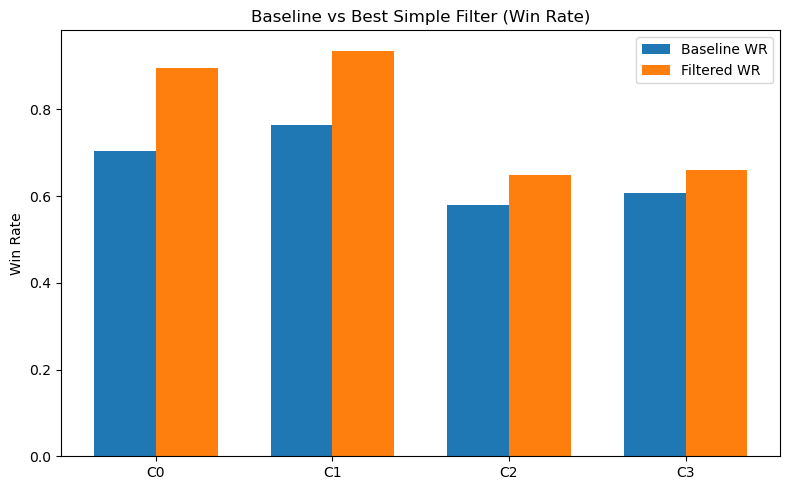

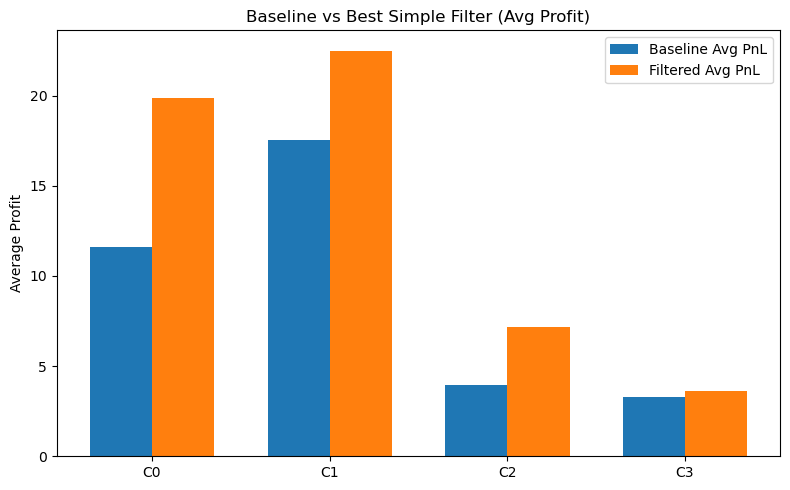

In [8]:
# Visual charts: baseline vs best simple filters per cluster


# Pick best single filter per cluster (by win_rate, N >= 30)
best_single_per_cluster = []
for c in sorted(merged[TRADES_CLUSTER_COL].unique()):
    df_c = good_filters_df[good_filters_df["cluster"] == c]
    if len(df_c) == 0:
        continue
    row = df_c.sort_values("win_rate", ascending=False).iloc[0]
    best_single_per_cluster.append(row)

best_single_df = pd.DataFrame(best_single_per_cluster)
print("Best single filter per cluster (N >= 30):")
display(best_single_df)

# Baseline vs Filtered Win Rate
fig, ax = plt.subplots()
x = np.arange(len(best_single_df))
width = 0.35

ax.bar(x - width/2, best_single_df["baseline_wr"], width, label="Baseline WR")
ax.bar(x + width/2, best_single_df["win_rate"], width, label="Filtered WR")

ax.set_xticks(x)
ax.set_xticklabels([f"C{int(c)}" for c in best_single_df["cluster"]])
ax.set_ylabel("Win Rate")
ax.set_title("Baseline vs Best Simple Filter (Win Rate)")
ax.legend()
plt.tight_layout()
plt.show()

# Baseline vs Filtered Average Profit
fig, ax = plt.subplots()
ax.bar(x - width/2, best_single_df["baseline_avg"], width, label="Baseline Avg PnL")
ax.bar(x + width/2, best_single_df["avg_profit"], width, label="Filtered Avg PnL")

ax.set_xticks(x)
ax.set_xticklabels([f"C{int(c)}" for c in best_single_df["cluster"]])
ax.set_ylabel("Average Profit")
ax.set_title("Baseline vs Best Simple Filter (Avg Profit)")
ax.legend()
plt.tight_layout()
plt.show()


In [9]:
# summarizing robustness & improvements what a pain in here 1 AM still up

# 
def add_table_from_df(document, df, title=None):
    if title:
        document.add_heading(title, level=2)
    table = document.add_table(rows=1, cols=len(df.columns))
    hdr_cells = table.rows[0].cells
    for j, col in enumerate(df.columns):
        hdr_cells[j].text = str(col)
    for _, row in df.iterrows():
        row_cells = table.add_row().cells
        for j, col in enumerate(df.columns):
            row_cells[j].text = str(row[col])
    document.add_paragraph("")

def build_docx_report(
    baseline_df,
    best_single_df,
    good_combo_df,
    output_path=REPORT_DOCX_PATH
):
    doc = Document()
    doc.add_heading("Imperium Data Challenge – Robustness & Improvements", level=1)

    doc.add_paragraph(
        "This report summarizes robustness tests and performance improvements "
        "based on simple, interpretable filters applied to clusters of trades "
        "for XAUUSD systematic strategies."
    )

    add_table_from_df(doc, baseline_df, title="Baseline Performance per Cluster")

    add_table_from_df(
        doc,
        best_single_df[[
            "cluster", "filter", "N", "win_rate", "avg_profit",
            "baseline_N", "baseline_wr", "baseline_avg"
        ]],
        title="Best Simple Filters per Cluster (N ≥ 30)"
    )

    good_combo_top = (
        good_combo_df
        .sort_values(["cluster", "win_rate"], ascending=[True, False])
        .groupby("cluster")
        .head(3)
        .reset_index(drop=True)
    )
    add_table_from_df(
        doc,
        good_combo_top,
        title="Top 2-Filter Combinations per Cluster (N ≥ 20)"
    )

    doc.add_heading("Overfitting Risk and Robustness Considerations", level=2)
    doc.add_paragraph(
        "Filters were defined using coarse quantile-based thresholds (e.g. low/mid/high terciles) "
        "and simple time/session rules, to keep the model interpretable and to reduce data-mining risk. "
        "For each filter or combination, sample size (N) and economic intuition were considered. "
        "Very high in-sample win rates on small samples (e.g. N < 30) are treated as hypotheses, not "
        "production-ready rules, and would require validation on a separate out-of-sample period."
    )
    doc.add_paragraph(
        "A next step would be a time-based train/test split (e.g. first 2/3 of the year to design filters, "
        "last 1/3 to validate) or walk-forward evaluation. In this challenge, the focus is on identifying "
        "robust patterns such as: trend-following clusters performing best under high-ADX regimes, "
        "range-trading clusters working better during specific sessions/days, and volatile breakout clusters "
        "benefiting from simple spread and session filters."
    )

    doc.save(output_path)
    print(f"Report saved to: {output_path}")

build_docx_report(baseline_df, best_single_df, good_combo_df)


Report saved to: imperium_robustness_improvements_report.docx


In [ ]:
#pushed yaaaaay